In [62]:
%matplotlib notebook
%config InlineBackend.figure_format='retina'  # for hi-dpi displays

In [63]:
#import sys
#sys.stdout = open('/dev/stdout', 'w')
import numpy as np

# 1. Read data

You can get a list of files and store the names in a list.

In [115]:
import glob
imgs = glob.glob('./*.mar2300')
imgs

['./acet-p0_170802_001.mar2300', './qtz_171012_001.mar2300']

# 2. Choose an X-ray diffraction image file

Index for a data image file to test

In [116]:
idx_file = 1
sample = imgs[idx_file]
print(sample)

./qtz_171012_001.mar2300


# 3. Read diffraction image

In [117]:
import lxml
import fabio
import matplotlib.pyplot as plt

In [118]:
#help(fabio.open)

Below we read the file and then flip the image to match with the way `poni` file was obtained.

In [119]:
data = fabio.open(sample).data

In [120]:
img = data[::-1]
print(img)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


# 4. Get a calibration file (poni)

`pyFAI` is the package to process diffraction images.

In [121]:
import pyFAI
poni = pyFAI.load("./LaB6-170815.poni")
print(poni)

Detector Detector	 Spline= None	 PixelSize= 1.500e-04, 1.500e-04 m
Wavelength= 7.107300e-11m
SampleDetDist= 2.167997e-01m	PONI= 1.726270e-01, 1.721638e-01m	rot1=0.004237  rot2= 0.002591  rot3= 0.000000 rad
DirectBeamDist= 216.802mm	Center: x=1141.635, y=1154.591 pix	Tilt=0.285 deg  tiltPlanRotation= 148.554 deg


# 5. Prepare a JCPDS card for phase identification

In [132]:
import ds_jcpds as jcpds

P = 0. ; T = 300. ; wavelength = 0.71073
j = jcpds.JCPDS(filename = 'sio2-stv.jcpds')
#j = jcpds.JCPDS(filename = 'acet.jcpds')
j.cal_dsp(P, T)
tth_jcpds, intensity_jcpds = j.get_tthVSint(wavelength)

# 6. Now make a cake

In [123]:
#help(poni.integrate2d)
#help(poni)

In [128]:
tth, intensity = poni.integrate1d(img, 2300, unit="2th_deg", method='csr')

In [129]:
intensity_cake, tth_cake, chi_cake = poni.integrate2d(img, 2300, 360, unit="2th_deg", method='csr')

<IPython.core.display.Javascript object>


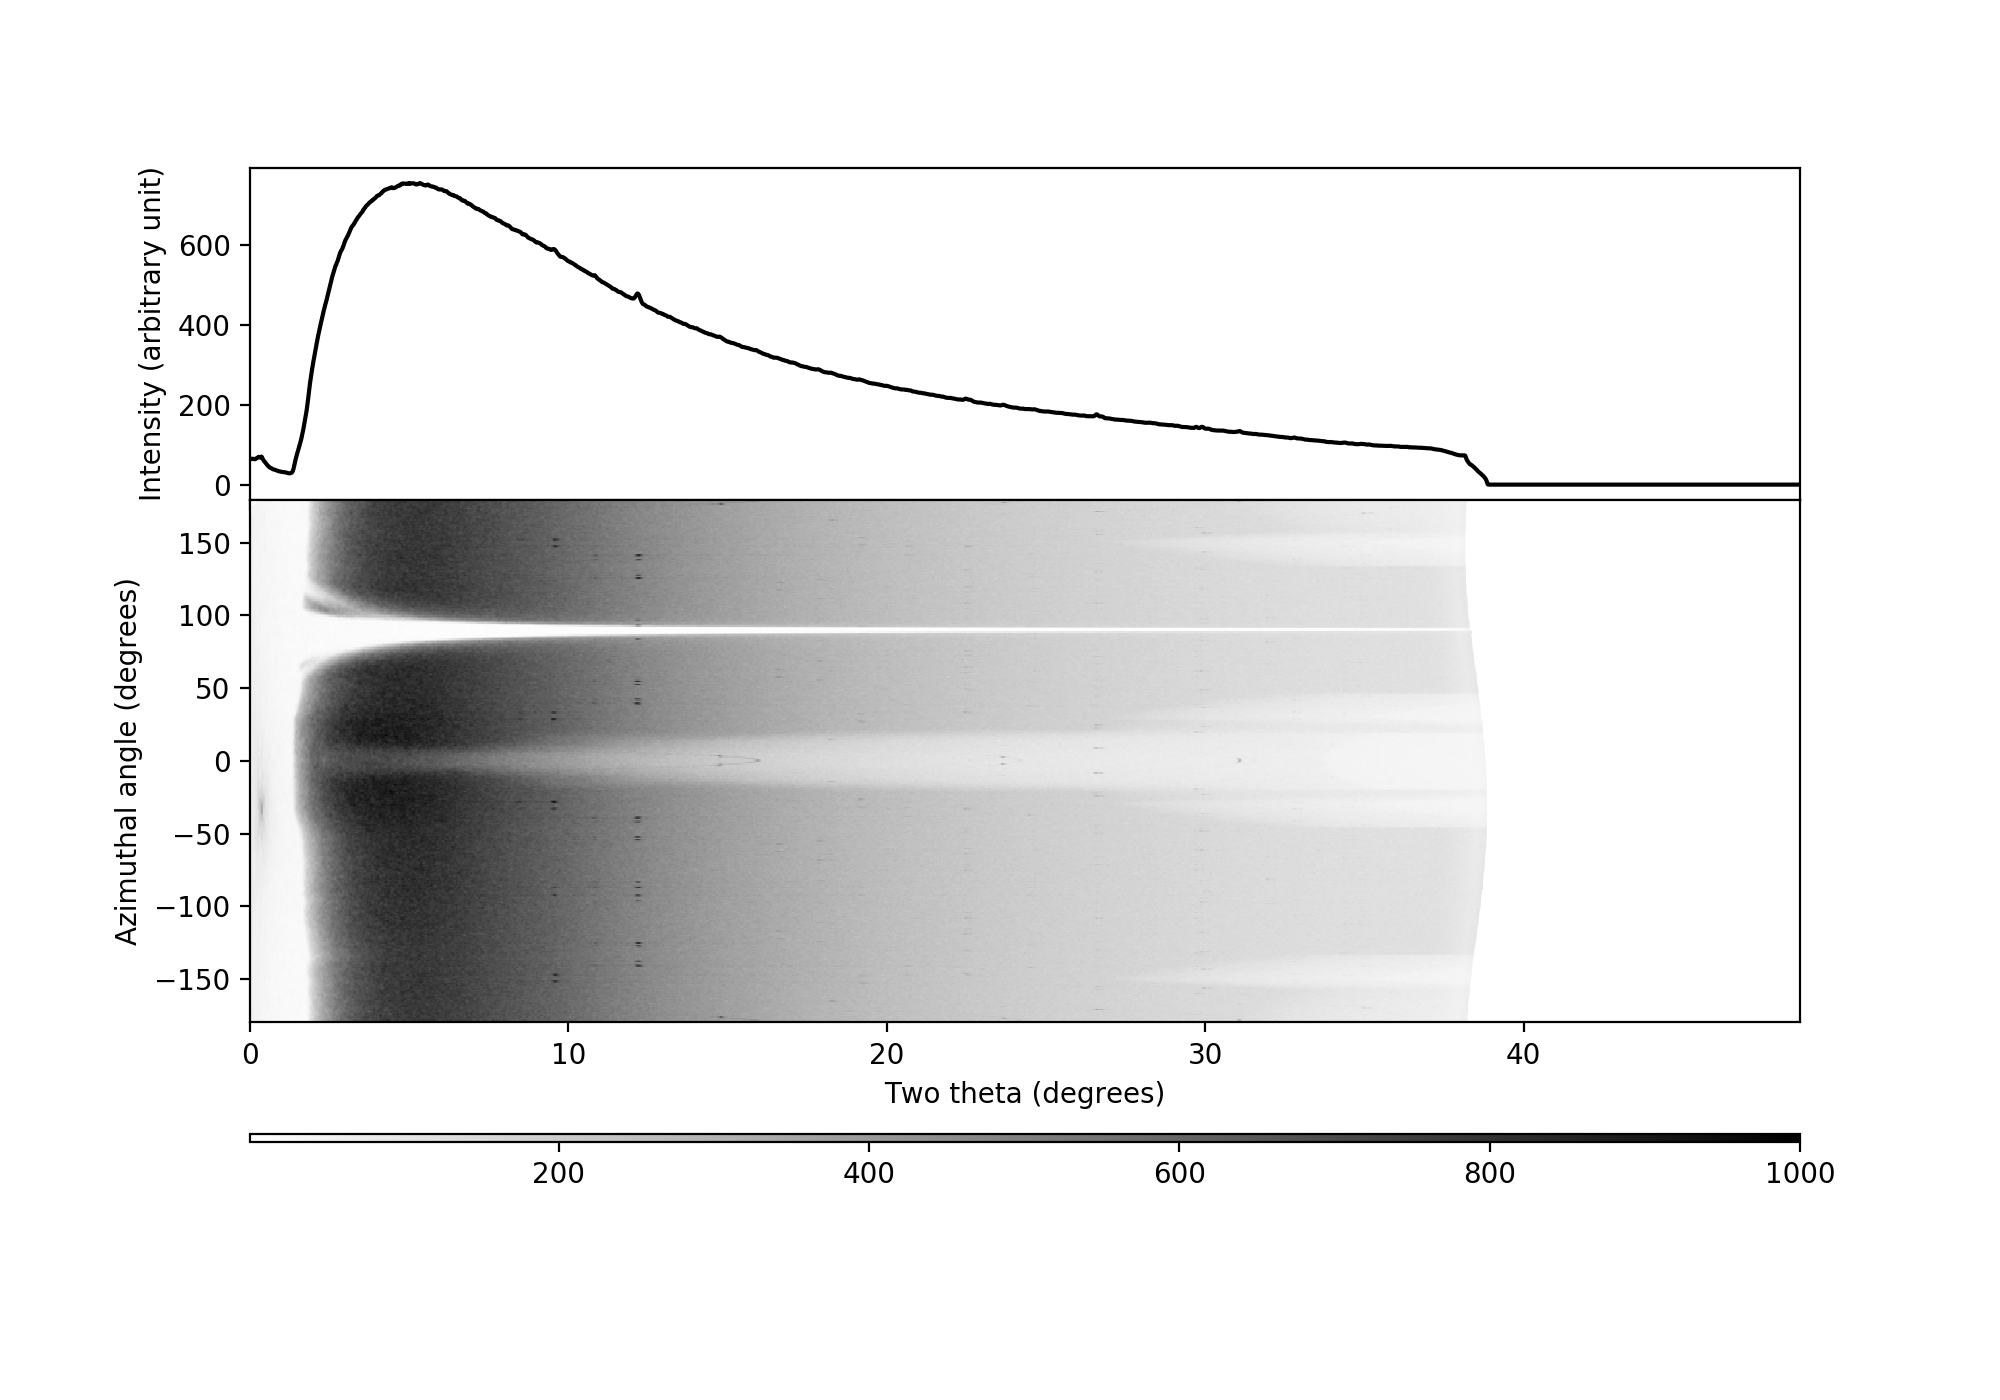

In [130]:
f, ax = plt.subplots(2, 1, figsize=(10,7), sharex=True, gridspec_kw = {'height_ratios':[4, 9]})
f.subplots_adjust(hspace=0)
cax = ax[1].imshow(intensity_cake, origin="lower", extent=[tth_cake.min(), tth_cake.max(), chi_cake.min(), chi_cake.max()], 
           aspect="auto", cmap="gray_r", clim=(1, 1.e3))
cbar = f.colorbar(cax, orientation='horizontal', aspect=200)
ax[0].plot(tth, intensity, 'k')
ax[1].set_xlabel("Two theta (degrees)")
ax[1].set_ylabel("Azimuthal angle (degrees)")
ax[0].set_ylabel("Intensity (arbitrary unit)")
plt.autoscale(enable=True, axis=u'both', tight=True)
bar_scale = 1./100. * intensity.max()
#ax[0].vlines(tth_jcpds, intensity.min(), intensity_jcpds * bar_scale, colors='b')
#for t in tth_jcpds:
#    ax[1].axvline(x=t, color='b', lw=0.5)
#plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


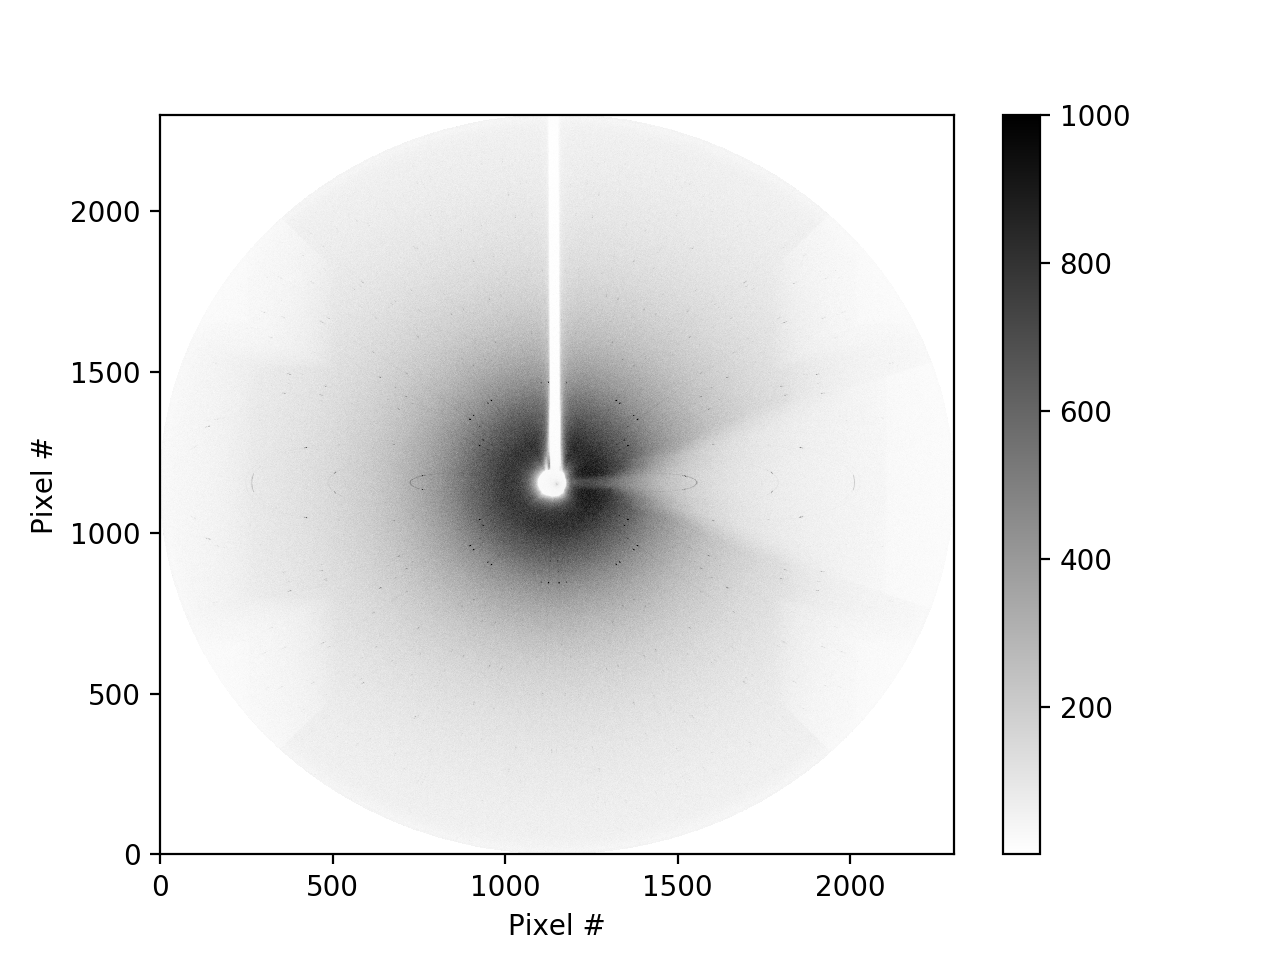

In [112]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax = plt.imshow(img, origin="lower", aspect="auto", cmap="gray_r", clim=(1, 1.e3))
cbar = f.colorbar(ax, orientation='horizontal', aspect=200)
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.colorbar()

xylist = []
def onclick(event):
    xylist.append(event.xdata)
    xylist.append(event.ydata)
    #if event.dblclick:
    #    x = event.xdata
    #    xlist.append(x)
    #    y = event.ydata
    #    ylist.append(y)
    return
cid = fig.canvas.mpl_connect('button_press_event', lambda event: onclick(event))

plt.show()

In [133]:
print(xylist)
x = xylist[len(xylist)-2]
y = xylist[len(xylist)-1]

[805.10499621975782, 1452.2462121212122, 885.96641631032116, 1366.1832034983415, 897.74127777197941, 1350.5470643959361, 897.74127777197941, 1350.5470643959361, 897.74127777197941, 1350.5470643959361]


In [139]:
geom = poni.getFit2D()
detdist = geom.get('directDist')
centx = geom.get('centerX')
centy = geom.get('centerY')
cent = [centx,centy]
print('Center: %s' % cent)
print('Point: [%.8s,%.8s]' % (x,y))
#tth = poni.tth(np.array([x]),np.array([y]))*180./np.pi
tth = np.arctan((np.sqrt(((centx-np.array([x]))**2)+((centy-np.array([y]))**2))*0.150)/detdist)*180.0/np.pi
print(('two-theta = %.6s') % float(tth))

Center: [1141.6353850572314, 1154.5911083867538]
Point: [897.7412,1350.547]
two-theta = 12.213


In [140]:
def getrec(x,y,cent):
    if (x>=cent[0]) and (y>=cent[1]):
        width = 0.150*(2*(x-cent[0]))
        height = 0.150*(2*(y-cent[1]))
    if (x>=cent[0]) and (y<=cent[1]):
        width = 0.150*(2*(x-cent[0]))
        height = 0.150*(2*(cent[1]-y))
    if (x<=cent[0]) and (y<=cent[1]): 
        width = 0.150*(2*(cent[0]-x))
        height = 0.150*(2*(cent[1]-y))
    if (x<=cent[0]) and (y>=cent[1]):
        width = 0.150*(2*(cent[0]-x))
        height = 0.150*(2*(y-cent[1]))
    return width,height
width,height = getrec(x,y,cent)
print('width = %.6s' % width)
print('height = %.6s' % height)

width = 73.168
height = 58.786
